In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
import os
import cv2
import rasterio
from tensorflow.keras.utils import to_categorical,Sequence
from sklearn.model_selection import train_test_split
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class ImageDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, img_height, img_width, num_channels, num_classes):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.num_channels = num_channels
        self.num_classes = num_classes

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_image_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_images = np.zeros((len(batch_image_paths), self.img_height, self.img_width, self.num_channels))
        for i, image_path in enumerate(batch_image_paths):
            with rasterio.open(image_path) as src:
                img = src.read()
            img = np.transpose(img, (1, 2, 0))#i want chanels at the end
            img = cv2.resize(img, (self.img_width, self.img_height))
            img = img / 255.0# normalizationnnnnnnn
            batch_images[i] = img

        batch_labels = to_categorical(batch_labels, num_classes=self.num_classes)

        return batch_images, batch_labels

In [3]:
num_classes = 10  
img_height =64
img_width = 64 
batch_size = 32
dataset_directories = [r'D:\MO3 LAP\Datasets\EuroSATallBands\ds\images\remote_sensing\otherDatasets\sentinel_2\tif\AnnualCrop',
                r'D:\MO3 LAP\Datasets\EuroSATallBands\ds\images\remote_sensing\otherDatasets\sentinel_2\tif\Forest',
                r'D:\MO3 LAP\Datasets\EuroSATallBands\ds\images\remote_sensing\otherDatasets\sentinel_2\tif\HerbaceousVegetation',# النباتات العشبية
                r'D:\MO3 LAP\Datasets\EuroSATallBands\ds\images\remote_sensing\otherDatasets\sentinel_2\tif\Highway',
                r'D:\MO3 LAP\Datasets\EuroSATallBands\ds\images\remote_sensing\otherDatasets\sentinel_2\tif\Industrial',
                r'D:\MO3 LAP\Datasets\EuroSATallBands\ds\images\remote_sensing\otherDatasets\sentinel_2\tif\Pasture',#المراعي
                r'D:\MO3 LAP\Datasets\EuroSATallBands\ds\images\remote_sensing\otherDatasets\sentinel_2\tif\PermanentCrop',
                r'D:\MO3 LAP\Datasets\EuroSATallBands\ds\images\remote_sensing\otherDatasets\sentinel_2\tif\Residential',
                r'D:\MO3 LAP\Datasets\EuroSATallBands\ds\images\remote_sensing\otherDatasets\sentinel_2\tif\River',
                r'D:\MO3 LAP\Datasets\EuroSATallBands\ds\images\remote_sensing\otherDatasets\sentinel_2\tif\SeaLake',]
image_paths = []
labels = []

for i, dataset_dir in enumerate(dataset_directories):
    for filename in os.listdir(dataset_dir):
        if filename.endswith('.tif'):
            image_paths.append(os.path.join(dataset_dir, filename))
            labels.append(i)

image_paths = np.array(image_paths)
labels = np.array(labels)   

train_image_paths, test_image_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.1, random_state=999)
train_image_paths, val_image_paths, y_train, y_val = train_test_split(train_image_paths, y_train, test_size=0.2, random_state=999)

train_generator = ImageDataGenerator(train_image_paths, y_train, batch_size, img_height, img_width, 13, num_classes)
val_generator = ImageDataGenerator(val_image_paths, y_val, batch_size, img_height, img_width, 13, num_classes)
test_generator = ImageDataGenerator(test_image_paths, y_test, batch_size, img_height, img_width, 13, num_classes)

In [8]:
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='elu', input_shape=(64, 64, 13), padding='same'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='elu', padding='valid'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(Flatten())
model.add(Dense(120, activation='elu'))
model.add(Dense(84, activation='elu'))
model.add(Dense(10, activation='softmax'))

'''
RULES: 
   output shape of conv = (int([input_shape - kernal_size + 2*padding]/strides)+1)
   output shape of pool = (int([input_shape - pool_size + 2*padding]/strides)+1) 
   
   num of params of a 2d layer = (kernal_w*kernal_h*input_channels+1)*(#kernals)
   num of params of a 1d layer = (num_of_nuerons*input_shape)+num_of_nuerons
EXPECTED PARAMETERS: 


-Any pooling layer is not trainable, no parameters
-Conv2D = (5*5*13+1)*6 
-Conv2D = (5*5*6+1)*16
-dense =  (3136*120)+120
-dense =  (120*84)+84
-dense =  (84*10)+10
'''


'\nRULES: \n   output shape of conv = (int([input_shape - kernal_size + 2*padding]/strides)+1)\n   output shape of pool = (int([input_shape - pool_size + 2*padding]/strides)+1) \n   \n   num of params of a 2d layer = (kernal_w*kernal_h*input_channels+1)*(#kernals)\n   num of params of a 1d layer = (num_of_nuerons*input_shape)+num_of_nuerons\nEXPECTED PARAMETERS: \n\n\n-Any pooling layer is not trainable, no parameters\n-Conv2D = (5*5*13+1)*6 \n-Conv2D = (5*5*6+1)*16\n-dense =  (3136*120)+120\n-dense =  (120*84)+84\n-dense =  (84*10)+10\n'

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 6)         1956      
                                                                 
 average_pooling2d_2 (Averag  (None, 32, 32, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        2416      
                                                                 
 average_pooling2d_3 (Averag  (None, 14, 14, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [39]:
model.fit(train_generator, epochs=5, validation_data=val_generator)# we trained this cell more than 10 times ~= 50 epochs

Epoch 1/5
608/608 [==============================] - 123s 203ms/step - loss: 0.1016 - accuracy: 0.9682 - val_loss: 1.4230 - val_accuracy: 0.7924
Epoch 2/5
608/608 [==============================] - 130s 214ms/step - loss: 0.1187 - accuracy: 0.9634 - val_loss: 1.0527 - val_accuracy: 0.8432
Epoch 3/5
608/608 [==============================] - 116s 191ms/step - loss: 0.0867 - accuracy: 0.9728 - val_loss: 1.0865 - val_accuracy: 0.8292
Epoch 4/5
608/608 [==============================] - 117s 192ms/step - loss: 0.1047 - accuracy: 0.9673 - val_loss: 1.2787 - val_accuracy: 0.8175
Epoch 5/5
608/608 [==============================] - 116s 190ms/step - loss: 0.0909 - accuracy: 0.9720 - val_loss: 1.2402 - val_accuracy: 0.8060


In [40]:
model.evaluate(test_generator)

85/85 [==============================] - 11s 134ms/step - loss: 1.2978 - accuracy: 0.8115


[1.2977800369262695, 0.8114814758300781]

In [41]:
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = y_test

85/85 [==============================] - 12s 140ms/step


In [ ]:
cm = confusion_matrix(y_true, y_pred)

'''[
for 2 classes:
                    ACTUAL
                     N  P
            PRED  N [TN FP
            ICTED P  FN TP]

for more classes :
                         ACTUAL
                      0     1     2 ... 
            PRE 0 [T0(0) F1(1) F2(2) 
            DIC 1  F0(0) T1(1) F2(2)
            TED 2  F0(0) F1(1) T2(2)]
                .
                .
                .
            ] 
            note that for multi class:
            to calc the measurs for class x, take the values you need only from row and column (x)


precision --> TP/(TP + FP)
recall --> TP/(TP + FN)
f1 --> mean of precision and recall
'''

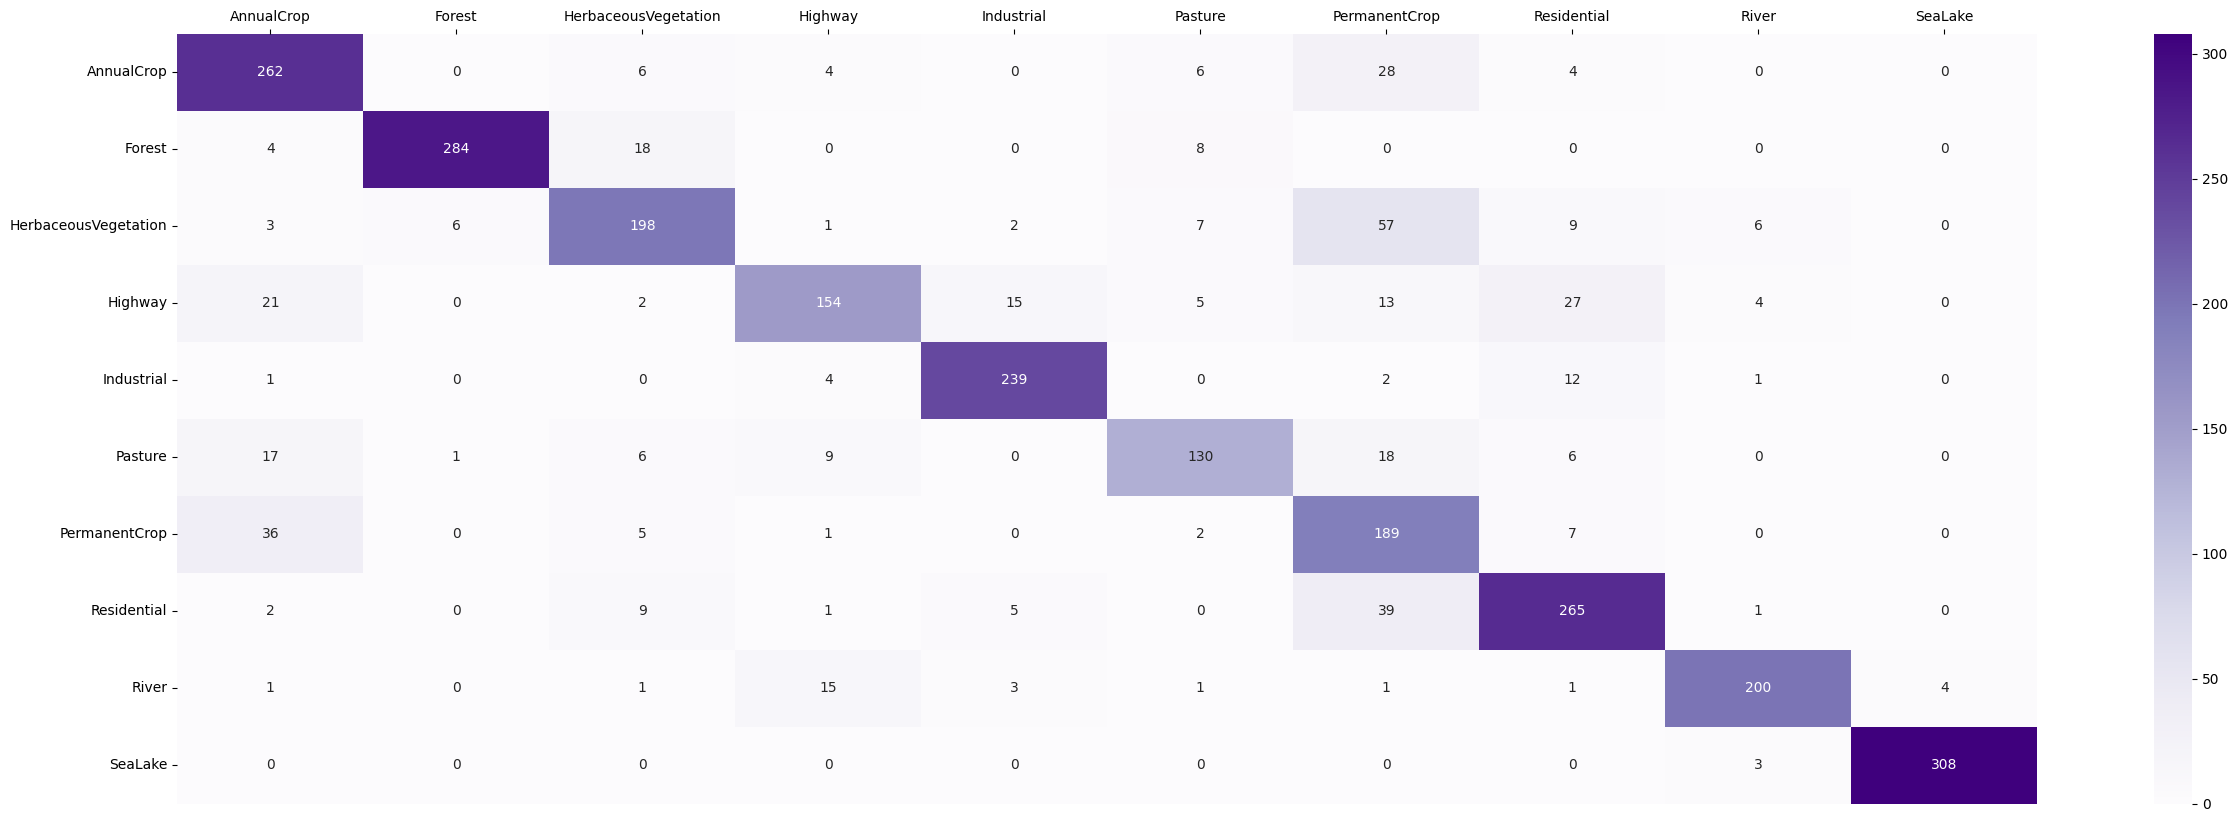

In [65]:
classes = [name for name in os.listdir(r'D:\MO3 LAP\Datasets\EuroSATallBands\ds\images\remote_sensing\otherDatasets\sentinel_2\tif') if os.path.isdir(os.path.join(r'D:\MO3 LAP\Datasets\EuroSATallBands\ds\images\remote_sensing\otherDatasets\sentinel_2\tif', name))]

df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
plt.figure(figsize=(30, 10))
ax= sn.heatmap(df_cm, annot=True, fmt='g',cmap='Purples')
ax.xaxis.tick_top()
plt.show()


In [63]:
report=classification_report(y_true, y_pred)
print(report[0:600])

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       310
           1       0.84      0.97      0.90       314
           2       0.78      0.79      0.79       289
           3       0.66      0.66      0.66       241
           4       0.94      0.75      0.83       259
           5       0.68      0.68      0.68       187
           6       0.62      0.67      0.64       240
           7       0.83      0.74      0.78       322
           8       0.90      0.92      0.91       227
           9       1.00      0.98      0.99       311

    
